# Sentiment Classification the old-fashioned way

* Naive Bayes
* Logistic Regression
* Ngrams

本筆記本的目的是展示如何透過經典技術（如朴素貝葉斯、邏輯迴歸和 Ngrams）進行情感分類。

### The IMDB dataset

大型電影評論資料集包含來自 IMDB 的 50,000 篇評論。將使用 fast.ai 資料集在 AWS Open Datasets 上提供的版本。

此資料集包含相等數量的正面與負面評論。
* 作者只考慮高度兩極化的評論。
* 負面評論的評分為小於等於 4 分
* 正面評論的評分為大於等於 7 分。
* 中立評論未包含在資料集中。
* 資料集被分為訓練集和測試集，訓練集包含相同的 25,000 篇已標記評論。


情感分類任務的目標是預測給定文本的極性（正面或負面）。

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd

df = pd.read_csv("hf://datasets/scikit-learn/imdb/IMDB Dataset.csv")
df.head()

c:\anaconda\envs\py312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


### Extract the movie reviews from the sample IMDb data set.

In [3]:
# Extract the movie reviews
movie_reviews = df['review']

print(movie_reviews.head())

0    One of the other reviewers has mentioned that ...
1    A wonderful little production. <br /><br />The...
2    I thought this was a wonderful way to spend ti...
3    Basically there's a family where a little boy ...
4    Petter Mattei's "Love in the Time of Money" is...
Name: review, dtype: object


### The IMDb Vocabulary

* 對文本進行清理和標記化處理，將評論拆分為單詞列表。
* 統計所有單詞的出現頻率，並過濾掉低頻詞和停用詞。
* 將剩餘的詞彙存儲為詞彙表，並分配唯一的索引。

In [4]:
from collections import Counter
from nltk.corpus import stopwords
import re

# Define a function to preprocess text
def preprocess_text(text):
    # Remove special characters and convert to lowercase
    text = re.sub(r"[^a-zA-Z\s]", "", text).lower()

    # Tokenize the text
    tokens = text.split()

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

# Initialize a Counter object to count word frequencies
word_counter = Counter()

# Process each review in the dataset
for review in df["review"]:
    tokens = preprocess_text(review)
    word_counter.update(tokens)

# Filter out low-frequency words (e.g., words appearing less than 5 times)
min_freq = 5
vocabulary = {word for word, count in word_counter.items() if count >= min_freq}

# Sort vocabulary alphabetically for consistency
vocabulary = sorted(vocabulary)

# Print the size of the vocabulary
print(f"Vocabulary size: {len(vocabulary)}")

# Save vocabulary with indices
vocab_with_indices = {word: idx for idx, word in enumerate(vocabulary)}

Vocabulary size: 44732


In [5]:
print(vocab_with_indices)

{'aa': 0, 'aaa': 1, 'aaargh': 2, 'aag': 3, 'aaliyah': 4, 'aames': 5, 'aamir': 6, 'aankhen': 7, 'aapke': 8, 'aardman': 9, 'aaron': 10, 'aarons': 11, 'ab': 12, 'aback': 13, 'abandon': 14, 'abandoned': 15, 'abandoning': 16, 'abandonment': 17, 'abandons': 18, 'abba': 19, 'abbas': 20, 'abbey': 21, 'abbie': 22, 'abbot': 23, 'abbott': 24, 'abbreviated': 25, 'abby': 26, 'abbys': 27, 'abc': 28, 'abcs': 29, 'abdalla': 30, 'abdomen': 31, 'abduct': 32, 'abducted': 33, 'abducting': 34, 'abduction': 35, 'abductions': 36, 'abductor': 37, 'abducts': 38, 'abdul': 39, 'abe': 40, 'abel': 41, 'aberration': 42, 'aberrations': 43, 'abetted': 44, 'abhay': 45, 'abhishek': 46, 'abhorrent': 47, 'abhors': 48, 'abide': 49, 'abiding': 50, 'abigail': 51, 'abigails': 52, 'abilities': 53, 'abilitiesbr': 54, 'ability': 55, 'abilitybr': 56, 'abit': 57, 'abject': 58, 'able': 59, 'ablebodied': 60, 'ably': 61, 'abnormal': 62, 'abnormally': 63, 'aboard': 64, 'abode': 65, 'abolished': 66, 'abomb': 67, 'abominable': 68, 'abo

#### 詞彙表的用途

1. 向量化評論: 使用詞彙表將每個評論轉換為數字向量（如 Bag of Words 或 TF-IDF）。
2. 模型輸入: 詞彙表是特徵矩陣（Document-Term Matrix, DTM）的基礎，用於訓練 Naive Bayes 或 Logistic Regression 模型。

### Map the movie reviews into a vector space

將電影評論映射到向量空間的過程，主要是將文字數據轉換為數字化的表示形式，讓機器學習模型可以理解並進行處理。
* **詞袋模型 (Bag of Words, BoW)**： 將文本表示為稀疏矩陣，其中每一行對應一個文檔，每一列對應語料庫中的一個唯一單詞。
* **TF-IDF (Term Frequency-Inverse Document Frequency)**： 詞袋模型的一種變體，根據單詞在文檔和整個語料庫中的頻率為其分配重要性。
* **詞嵌入 (Word Embeddings，例如 Word2Vec、GloVe)**：根據單詞的語義將其映射到稠密且連續的向量空間。
* **預訓練模型** (例如 BERT、Sentence Transformers)：將整個句子或文檔編碼為稠密向量。

In [6]:
from sklearn.model_selection import train_test_split

train_texts, test_texts, train_labels, test_labels = train_test_split(
    df["review"],
    df["sentiment"],
    test_size=0.2,
    random_state=42
)

print(f"Size of Train texts: {len(train_texts)}")
print(f"Size of Test texts: {len(test_texts)}")

Size of Train texts: 40000
Size of Test texts: 10000


#### 使用 Bag of Words (詞袋模型)
在非深度學習的自然語言處理方法中，我們通常只關注評論中使用了哪些單詞，以及每個單詞出現的頻率。這種方法被稱為詞袋模型，它提供了一種非常簡單的方式來存儲文檔。

詞袋模型是一種簡單的文本向量化方法，它會：
* 將文本拆分為單詞（詞元化）。
* 建立一個詞彙表（所有出現過的唯一單詞）。
* 使用稀疏矩陣表示每個文本，矩陣的每一列對應詞彙表中的一個單詞，每一行對應一個文本，矩陣中的值是該單詞在文本中出現的次數。

換句話說:
* 對於每則評論，我們可以使用一個向量來記錄哪些單詞被使用以及每個單詞被使用的次數。
* 向量的長度等於詞彙表中的詞元數量，我們稱之為 n。
* 向量的索引對應於 IMDb 詞彙表中的詞元，而向量中的值則是對應詞元在評論中出現的次數。

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

# 使用 CountVectorizer 進行詞袋向量化
vectorizer = CountVectorizer(
    max_features=6000,
    stop_words=stopwords.words("english"),
    token_pattern=r"[^a-zA-Z\s]",
)
dtm = vectorizer.fit_transform(train_texts)


print("The len of vector: ", len(vectorizer.get_feature_names_out()))
print("The matrix shape: ", dtm.toarray().shape)

c:\anaconda\envs\py312\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'"] not in stop_words.
  warnings.warn(


The len of vector:  131
The matrix shape:  (40000, 131)


In [12]:
dtm.todense()[:10, :10]

matrix([[ 0,  0,  0,  2,  0,  0,  0,  0, 13,  3],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  7,  3],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  1,  0],
        [ 0,  0,  3,  0,  0,  0,  0,  0,  5,  3],
        [ 0,  0,  7,  0,  0,  0,  0,  0, 10,  1],
        [ 0,  0,  2,  0,  0,  0,  0,  0,  7,  2],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  2,  0,  0,  0,  0,  7,  1],
        [ 0,  0,  0,  6,  0,  0,  0,  0,  7,  0],
        [ 0,  0,  0,  4,  0,  0,  0,  0, 27,  2]], dtype=int64)

### Explore the sparsity of the document-term matrix

矩陣的稀疏性被定義為零值元素所佔的比例。
* 統計矩陣中的零值元素數量，並計算稀疏性。
* 可以通過熱圖（Heatmap）或其他可視化工具來展示矩陣的稀疏結構。

稀疏性是document-term matrix的一個重要特性，尤其是在文本數據處理中，理解稀疏性可以幫助我們選擇合適的數據壓縮技術、稀疏矩陣運算方法，以及優化模型的計算效率。

In [8]:
# 計算稀疏性
total_elements = dtm.shape[0] * dtm.shape[1]  # 矩陣中的總元素數
zero_elements = total_elements - dtm.count_nonzero()  # 零值元素數量
sparsity = zero_elements / total_elements  # 稀疏性

print(f"文檔-詞項矩陣的稀疏性: {sparsity:.5f}")

文檔-詞項矩陣的稀疏性: 0.92327


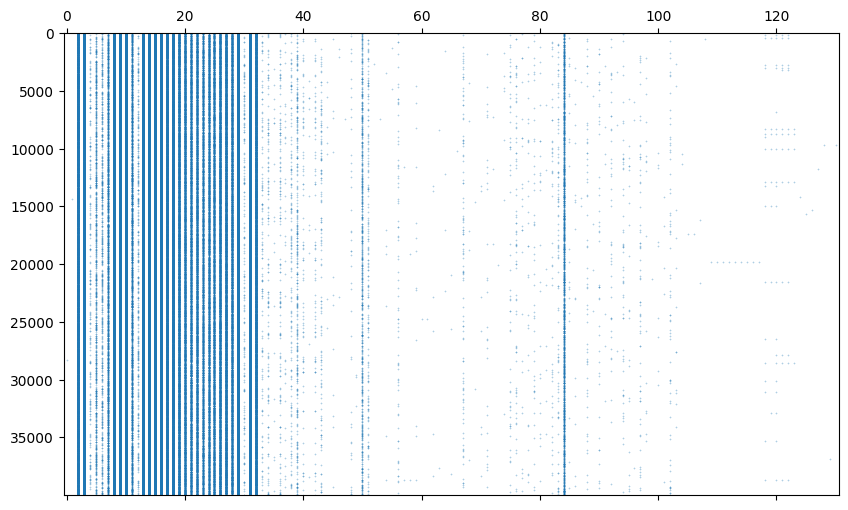

In [10]:
import matplotlib.pyplot as plt
# 將稀疏矩陣轉換為密集矩陣（方便可視化）
dense_matrix = dtm.toarray()


# 繪製熱圖
plt.figure(figsize=(10, 6))
plt.spy(dtm, markersize=0.10, aspect = 'auto')  
plt.show()

### Sparse Matrix Representation

稀疏矩陣（Sparse Matrix）是一種特殊類型的矩陣，其中大多數元素的值為零。由於零值在運算中通常不影響結果，因此稀疏矩陣的儲存和操作可以通過只記錄非零元素來大幅提高效率。
* 零值比例高：矩陣中大部分元素都是零值，非零值的比例相對很低。
* 節省空間：只儲存非零值及其位置信息，可以減少記憶體使用。
* 運算效率高：避免對零值進行不必要的運算，提升計算速度。

稀疏矩陣的表示法
* 壓縮稀疏行（Compressed Sparse Row, CSR）
* 壓縮稀疏列（Compressed Sparse Column, CSC）
* 坐標格式（Coordinate List, COO）

### Naive Bayes classifier

Naive Bayes分類器是一種基於貝氏定理的算法，用於從文本中推斷其所屬的類別（例如正面或負面評論）。

核心想法：
* 假設我們只知道文本中每個詞的出現次數（Bag of Words表示），而不考慮詞語的順序，我們仍然可以通過詞語的整體情感傾向來判斷評論的類別。
* Naive Bayes分類器通過計算每個詞在不同類別（正面或負面）中的出現概率，來進行分類。

需要的資訊：
1. 類別的先驗概率（Class Priors）
2. 詞語的條件概率（Token Likelihoods）

#### Naive Bayes分類器的運作原理
1. 計算類別的後驗概率
2. 使用條件獨立性假設
3. 預測類別

#### 訓練數據中的必要計算
1. 先驗概率（Prior Probabilities）
2. 詞語的類別出現次數（Class Occurrence Counts）
3. 詞語的類別似然比（Likelihood Ratios）

In [16]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score


df = pd.read_csv("hf://datasets/scikit-learn/imdb/IMDB Dataset.csv")

# 1. 文本轉換為Bag of Words表示
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df["review"])

# 2. 分割數據集
X_train, X_test, y_train, y_test = train_test_split(X, df["sentiment"], test_size=0.25, random_state=42)

In [17]:
# 3. 訓練Naive Bayes分類器
classifier = MultinomialNB()
classifier.fit(X_train, y_train)

# 4. 預測
y_pred = classifier.predict(X_test)

# 5. 評估準確率
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


# 測試新評論
new_review = ["I hate this movie"]
new_review_vectorized = vectorizer.transform(new_review)
prediction = classifier.predict(new_review_vectorized)
print("Prediction for new review:", prediction)

Accuracy: 0.84952
Prediction for new review: ['negative']


### Logistic Regression Classifier 
Logistic Regression Classifier 進行分類的過程與 Naive Bayes 類似，但 Logistic Regression 是一種基於概率模型的線性分類方法，常用於二元分類（如正面/負面、垃圾郵件/非垃圾郵件）。

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# 訓練 Logistic Regression 分類器
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

# 預測
y_pred = classifier.predict(X_test)

# 評估模型
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))


# 測試新評論
new_review = ["The movie was fantastic"]
new_review_vectorized = vectorizer.transform(new_review)
prediction = classifier.predict(new_review_vectorized)
print("Prediction for new review:", prediction)

Accuracy: 0.89344
Classification Report:
               precision    recall  f1-score   support

    negative       0.89      0.89      0.89      6157
    positive       0.89      0.90      0.90      6343

    accuracy                           0.89     12500
   macro avg       0.89      0.89      0.89     12500
weighted avg       0.89      0.89      0.89     12500

Prediction for new review: ['positive']


c:\anaconda\envs\py312\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### n-gram

n-gram 是一種文本表示方法，指的是由文本中連續的 n 個單位（如字符、音節或單詞）組成的序列。
* 1-gram（unigram）：每個單詞單獨作為一個特徵。例如："I love movies" → ["I", "love", "movies"]
* 2-gram（bigram）：每兩個連續單詞作為一個特徵。例如："I love movies" → ["I love", "love movies"]
* 3-gram（trigram）：每三個連續單詞作為一個特徵。例如："I love movies" → ["I love movies"]

使用 n-grams 的原因
* 捕捉上下文信息：
  * 使用 n-grams（尤其是 bigrams 和 trigrams）可以捕捉到詞語之間的上下文關係，而不僅僅是單個詞的出現頻率。
  * 例如，unigram 只能記錄單詞的頻率，而 bigram 和 trigram 可以捕捉到像 "not good" 或 "very bad" 這樣的短語，它們對情感分析非常重要。
* 更豐富的特徵：
  * 相比單純的 unigram，加入 bigram 和 trigram 可以使模型利用更多的特徵，從而更好地理解文本的語義。

特徵處理：Log-Count Ratio

* Log-Count Ratio 是一種特徵工程技術，用於計算每個 n-gram 在不同類別中的相對頻率。
  * 計算公式通常如下：
    $
    \text{Log-Count Ratio} = \log \left( \frac{\text{Count of n-gram in Positive Class} + 1}{\text{Count of n-gram in Negative Class} + 1} \right)
    $
  * 這種方法可以幫助模型更好地區分正面和負面情感。
* Binarized Features：
  * 特徵被二值化，表示某個 n-gram 是否出現在文檔中（出現為 1，否則為 0）。這樣可以減少特徵的噪聲，並防止某些高頻詞對模型的過度影響。


In [19]:
# Trigrams
vectorizer = CountVectorizer(ngram_range=(1,3), max_features=8000)
X = vectorizer.fit_transform(df["review"])

# 分割數據集
X_train, X_test, y_train, y_test = train_test_split(X, df["sentiment"], test_size=0.25, random_state=42)


# 訓練Naive Bayes分類器
classifier = MultinomialNB()
classifier.fit(X_train, y_train)

# 預測
y_pred = classifier.predict(X_test)

# 評估準確率
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


# 測試新評論
new_review = ["I hate this movie"]
new_review_vectorized = vectorizer.transform(new_review)
prediction = classifier.predict(new_review_vectorized)
print("Prediction for new review:", prediction)

Accuracy: 0.84632
Prediction for new review: ['negative']
